## 1. Dataset

### 1.1 Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import pandas as pd 
import seaborn as sns
#from plotnine import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_files
#from keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from sklearn.utils import shuffle
import numpy as np

import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Flatten, Dropout

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from keras.applications import MobileNetV2
sns.set()
plt.rcParams.update({'font.size': 18})

### 1.2 Loading Data

In [2]:
infile = "DataSet/squares.csv"
data = np.genfromtxt(infile, delimiter=",")

# define inputs and labels
inputs = data[:,1:]
inputs = inputs.astype('float32')/255
labels = data[:,0]
# Change labels of the dataset
# to find the FEN of the position, we don't need the square color
for i in range(len(labels)):
    if (labels[i]>=13):
        labels[i]=labels[i]-13
print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))

n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


inputs = (n_inputs, pixel_width, pixel_height) = (6400, 1024)
labels = (n_inputs) = (6400,)
X = (n_inputs, n_features) = (6400, 1024)


In [3]:
# Dataset notation
square2number = {
  
    "empty": 0,
    "black_pawn": 1,
    "black_rook": 2,
    "black_knight": 3,
    "black_bishop": 4,
    "black_queen": 5,
    "black_king": 6,
    "white_pawn": 7,
    "white_rook": 8,
    "white_knight": 9,
    "white_bishop": 10,
    "white_queen": 11,
    "white_king": 12

}
# I want the inverted map
number2square={}
for pieces,i in square2number.items():
        
        number2square[i]= pieces
        
# Fen Notation
Fen = {
  
    "1": 0,
    "p": 1,
    "r": 2,
    "n": 3,
    "b": 4,
    "q": 5,
    "k": 6,
    "P": 7,
    "R": 8,
    "N": 9,
    "B": 10,
    "Q": 11,
    "K": 12

}
number2Fen={}
for pieces,i in Fen.items():
        
        number2Fen[i]= pieces

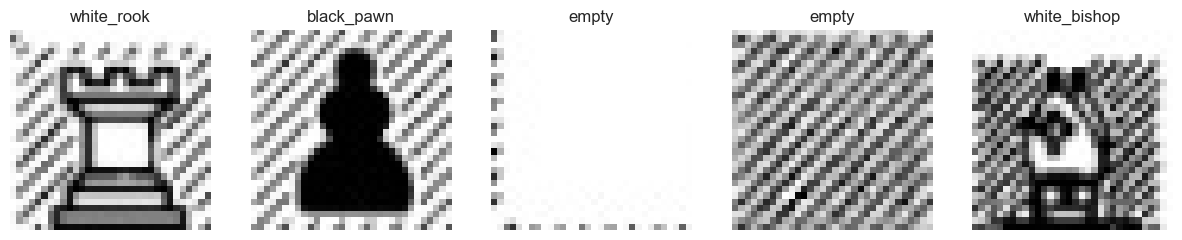

In [4]:
np.random.seed(5)
fig=plt.figure(figsize=(15,5))

# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)
for i in range(len(random_indices)):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    image = inputs[random_indices[i]].reshape(32, 32)
    plt.imshow(image, cmap="gray")
    plt.title(number2square[labels[random_indices[i]]])
plt.show()

### Split in test and training

In [5]:
# 75-25 train - (test,validation)
#and 50-50 validation-test

In [6]:
np.random.seed(5)
train_size = 0.6
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)
validation_size = 0.5
test_size = 1 - validation_size
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, train_size=validation_size,
                                                    test_size=test_size)

In [7]:
print("Number of training images: " + str(len(X_train)))
print("Number of test images: " + str(len(X_test)))
print("Number of validation images: " + str(len(X_valid)))
print('Train shape:')
print('X: ',X_train.shape)
print('y: ',Y_train.shape)

print('Test shape')
print('X: ',X_test.shape)
print('y: ',Y_test.shape)

print('Validation shape')
print('X: ',X_valid.shape)
print('y: ',Y_valid.shape)

Number of training images: 3840
Number of test images: 1280
Number of validation images: 1280
Train shape:
X:  (3840, 1024)
y:  (3840,)
Test shape
X:  (1280, 1024)
y:  (1280,)
Validation shape
X:  (1280, 1024)
y:  (1280,)


Class Distribution
piece                         label                         counts
empty                         0                             2444
black_pawn                    1                             342
black_rook                    2                             101
black_knight                  3                             65
black_bishop                  4                             75
black_queen                   5                             58
black_king                    6                             60
white_pawn                    7                             338
white_rook                    8                             88
white_knight                  9                             66
white_bishop                  10                            77
white_queen                   11                            66
white_king                    12                            60


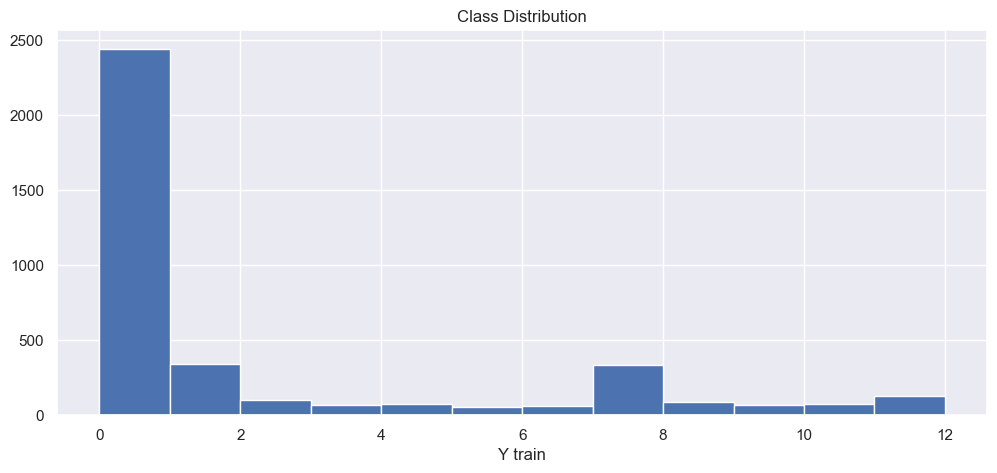

In [8]:
print("Class Distribution")
unique, counts = np.unique(Y_train, return_counts=True)
fig=plt.figure(figsize=(12,5))
plt.title('Class Distribution')
plt.hist(Y_train,bins=(0,1,2,3,4,5,6,7,8,9,10,11,12))
plt.xlabel('Y train')
plt.rcParams.update({'font.size': 30})
print("{}{}{}".format(str('piece').ljust(30),str('label').ljust(30),'counts'))
for i in range(len(number2square)):
    print("{}{}{}".format(number2square[unique[i]].ljust(30),str(i).ljust(30),(counts[i])))
#the distribution is imbalanced
plt.show()

# Data Augmentation

One should augment the data after Train and Test split. To work correctly one needs to make sure to augment data only from the train split.

If one augments data and before splitting the dataset, it will likely inject small variations of the train dataset into the test dataset. Thus the network will be overestimating its accuracy (and it might be over-fitting as well, among other issues).

In [9]:
datagen = ImageDataGenerator(
  rotation_range=2,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.02,
  zoom_range=0.05,
  fill_mode="nearest"
)

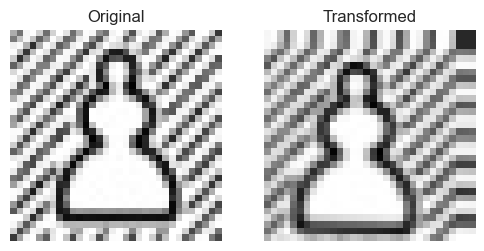

In [10]:
np.random.seed(5)
image = X_train[3].reshape(32, 32)
z=(datagen.flow(X_train[3].reshape(1, 32, 32, 1), batch_size=1))[0].reshape((1024))
fig=plt.figure(figsize=(6,3))
plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(image, cmap="gray")
plt.subplot(122)
image = z.reshape((32, 32))
plt.title('Transformed')
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()


In [11]:
size = 500 # new size per category
new_X_train =np.zeros(shape=(size*len(number2square), X_train.shape[1]))
new_Y_train =np.zeros(shape=(size*len(number2square)))

for i in range(len(number2square)):
    a=[]
    for j in range(len(Y_train)):
        if (Y_train[j]==i):
            a.append(j)  
    
    if (len(a)>=size):
        for k in range(size):
            
            new_Y_train[size*i + k]=Y_train[a[k]]
            new_X_train[size*i + k]=X_train[a[k]]
            
    else:
        for k in range(len(a)):
            new_Y_train[size*i + k]=Y_train[a[k]]
            new_X_train[size*i + k]=X_train[a[k]]
            
        for t in range(size-len(a)):
            s=np.random.randint(0,len(a))
            new_Y_train[size*i +len(a)+ t]=new_Y_train[size*i]
            new_X_train[size*i +len(a)+ t]=(datagen.flow(X_train[a[s]].reshape(1, 32, 32, 1), batch_size=1))[0].reshape((1024))
            


In [12]:
print((new_Y_train).shape)
print((new_X_train.shape))

(6500,)
(6500, 1024)


In [13]:
indices = np.arange(len(new_Y_train))
np.random.shuffle(indices)

new_X_train = new_X_train[indices]
new_Y_train = new_Y_train[indices]


In [14]:
X_train = new_X_train
Y_train = new_Y_train

print((X_train.shape))
print((Y_train.shape))

(6500, 1024)
(6500,)


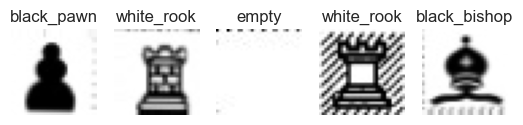

In [16]:
np.random.seed(5)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)
for i in range(len(random_indices)):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    image = new_X_train[random_indices[i]].reshape(32, 32)
    plt.imshow(image, cmap="gray")
    plt.title(number2square[new_Y_train[random_indices[i]]])
plt.show()

Class Distribution
piece                         label                         counts
empty                         0                             500
black_pawn                    1                             500
black_rook                    2                             500
black_knight                  3                             500
black_bishop                  4                             500
black_queen                   5                             500
black_king                    6                             500
white_pawn                    7                             500
white_rook                    8                             500
white_knight                  9                             500
white_bishop                  10                            500
white_queen                   11                            500
white_king                    12                            500


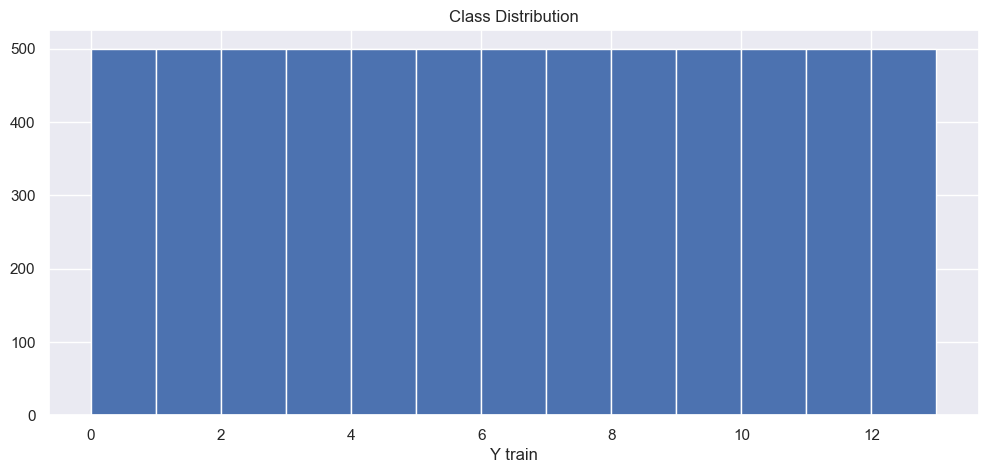

In [17]:
print("Class Distribution")
unique, counts = np.unique(Y_train, return_counts=True)
fig=plt.figure(figsize=(12,5))
plt.title('Class Distribution')
plt.hist(Y_train,bins=(0,1,2,3,4,5,6,7,8,9,10,11,12,13))
plt.xlabel('Y train')
plt.rcParams.update({'font.size': 30})
print("{}{}{}".format(str('piece').ljust(30),str('label').ljust(30),'counts'))
for i in range(len(number2square)):
    print("{}{}{}".format(number2square[unique[i]].ljust(30),str(i).ljust(30),(counts[i])))
#the distribution is imbalanced
plt.show()

In [18]:
# one-hot representation of labels
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_valid = to_categorical(Y_valid)

## PCA

In [19]:
print(X_train.shape)
print(X_train.T.shape)

(6500, 1024)
(1024, 6500)


https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [20]:
np.random.seed(5)
scaler = StandardScaler()
scaler.fit(X_train)
new_X_train_img = scaler.transform(X_train)
new_X_valid_img = scaler.transform(X_valid)
new_X_test_img = scaler.transform(X_test)

In [21]:
pca = PCA().fit(new_X_train_img)

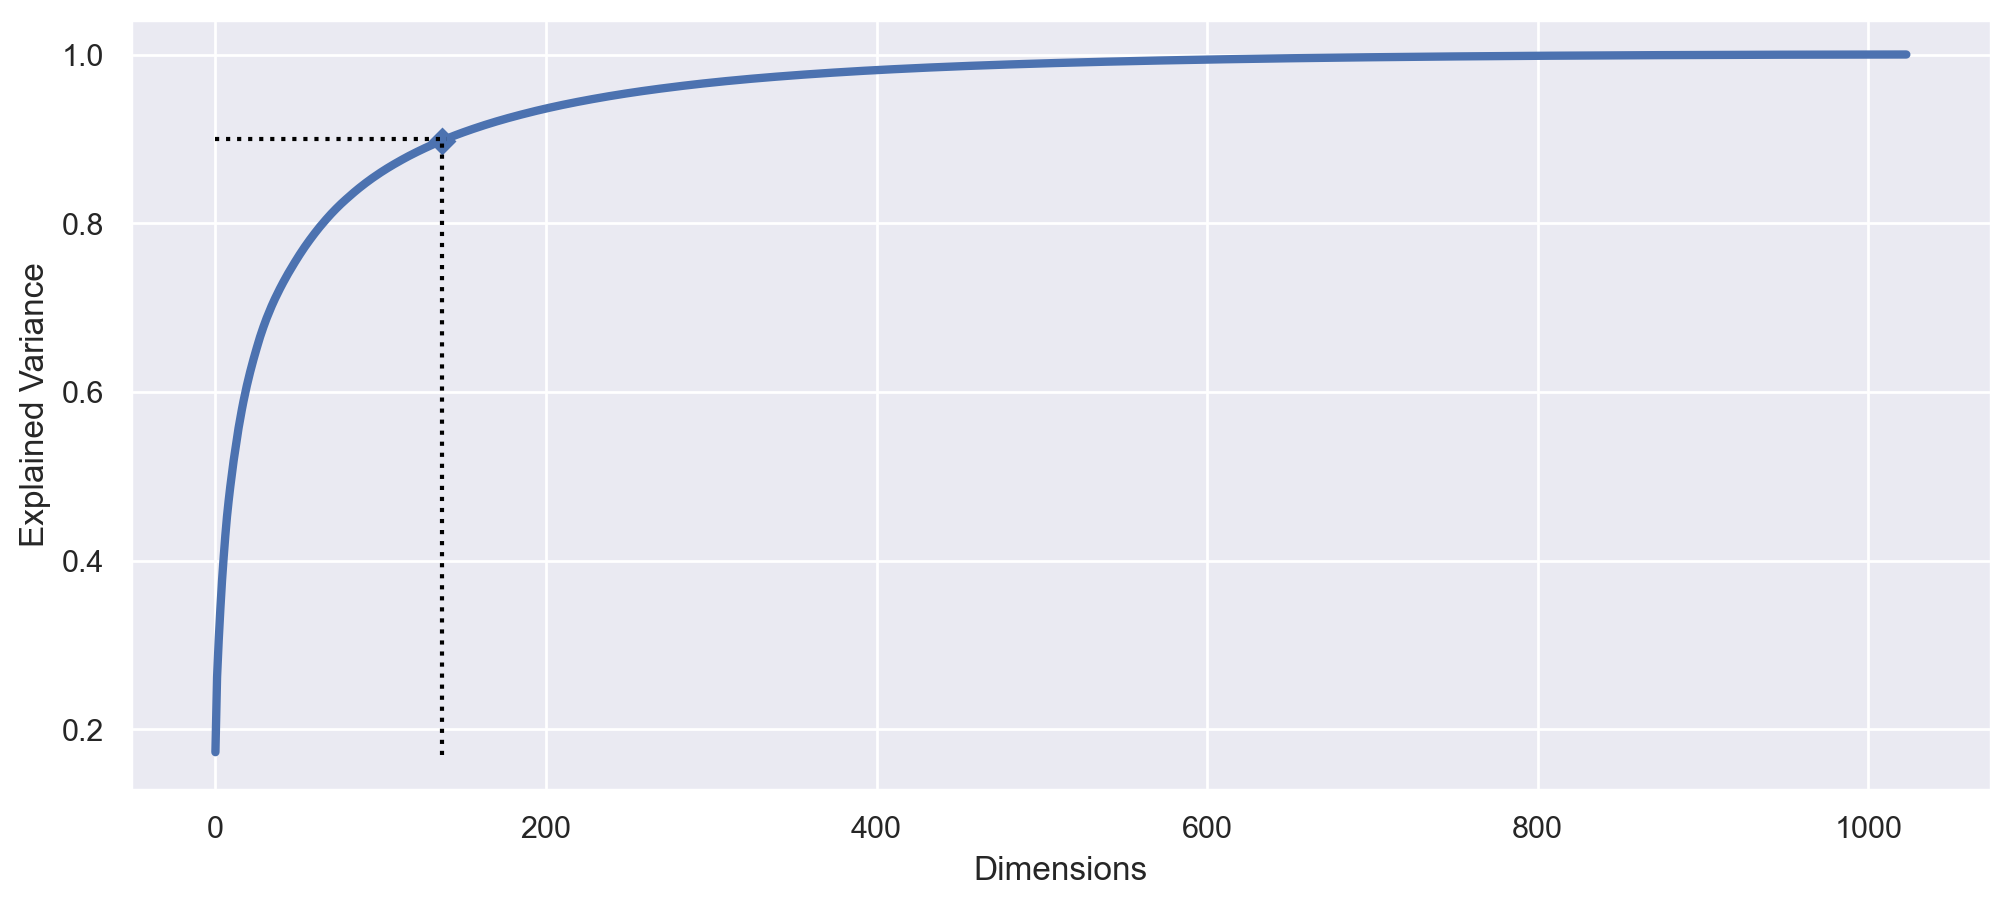

In [23]:
plt.figure(figsize=(12, 5),dpi=200)
#plt.scatter(137,pca.explained_variance_ratio_.cumsum()[137],color='black')
plt.plot(pca.explained_variance_ratio_.cumsum(),'-D',markevery=[137], lw=3)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.hlines(y = 0.9,xmin=0.0, xmax=140, color = 'black', linestyle = ':')
plt.vlines(x = 137,ymin=0.17, ymax=0.902, color = 'black', linestyle = ':')

plt.show()

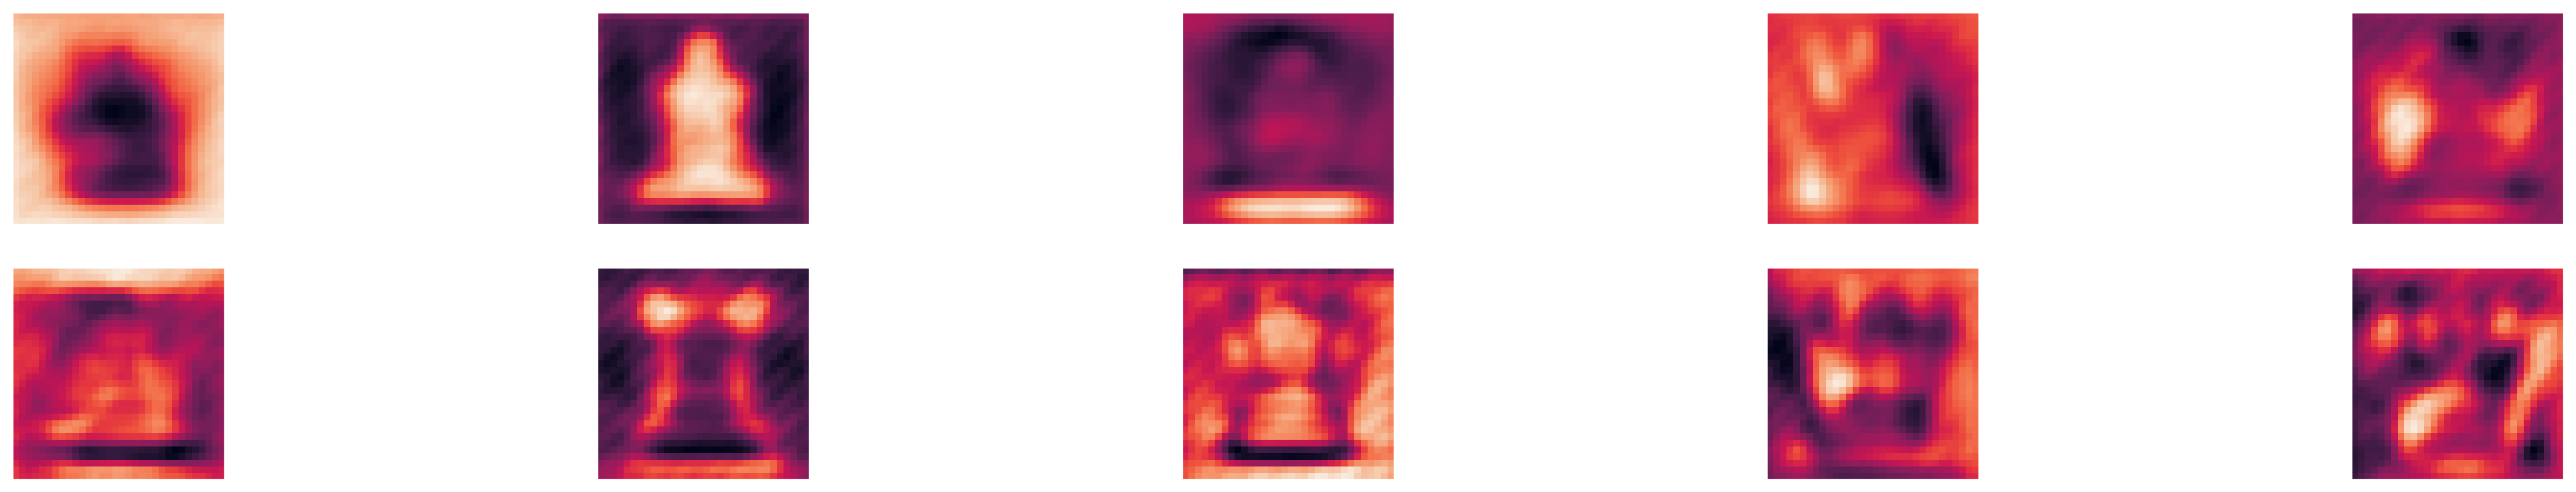

In [24]:
cov = np.cov(X_train.T)
eigen = np.linalg.eig(cov)
eigen[0].shape
fig = plt.figure(figsize =(30,5),dpi=200)
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(eigen[1][:,i].reshape(32,32)))


## FUNCTIONS

In [37]:
def PCA_func(X_train,X_valid,X_test,i):
    
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_valid = pca.transform(X_valid)
    X_test = pca.transform(X_test)
    
    return (X_train,X_valid,X_test)

In [27]:
def zero_one_loss(Y_test , Y_pred ):
    loss=0
    for i in range(len(Y_test)):
        if((np.argmax(Y_test[i]))!=(np.argmax(Y_pred[i]))):
            loss +=1
    return loss/len(Y_test)
    



lr = lr * (1. / (1. + decay * iterations))

In [28]:
def DNN_model(n_neurons_per_layer, n_layers, n_categories, eta, lmbd , opt ,inputsize,activation, epochs):
    momentum = 0.8
    decay_rate = eta / epochs
    model = Sequential()
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neurons_per_layer,activation=activation,kernel_regularizer=regularizers.l2(lmbd),input_dim=inputsize))
        else: 
            #Subsequent layers are capable of automatic shape inferencing
            #model.add(Dropout(0.5))
            model.add(Dense(n_neurons_per_layer,activation=activation,kernel_regularizer=regularizers.l2(lmbd)))
    
    model.add(Dense(n_categories,activation='softmax'))  #2 outputs - ordered and disordered (softmax for prob)
    if (opt==optimizers.SGD):
        model.compile(loss='categorical_crossentropy',optimizer=opt(lr=eta, momentum=momentum, decay=decay_rate, nesterov=False),metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy',optimizer=opt(lr=eta),metrics=['accuracy'])
    return model
 

Random Search. Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain

In [29]:
def RandomSearch(n_neurons_per_layer,n_layers,eta,lmbd,opt,activation, epochs):
    i = np.random.randint(len(n_neurons_per_layer))
    j = np.random.randint(len(n_layers))
    k = np.random.randint(len(eta))
    t = np.random.randint(len(lmbd))
    w = np.random.randint(len(opt))
    s = np.random.randint(len(activation))
    print('n_neurons_per_layer :{} \nn_layers :{} \neta :{} \nlmbd :{} \nopt :{} \nactivation :{}'.format(n_neurons_per_layer[i], n_layers[j], eta[k], lmbd[t] , opt[w] ,activation[s]))
    return DNN_model(n_neurons_per_layer[i], n_layers[j], n_categories, eta[k], lmbd[t] , opt[w] ,inputsize,activation[s], epochs)


In [30]:
def history_plot(history,score,zero_one):
    title=['loss','val_loss','accuracy','val_accuracy']
    index=[]
# look into training history
    fig=plt.figure(figsize=(30,20),dpi=300)
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.title(title[i],weight="bold",size=22)

        for j in range(len(history)):
            plt.plot(history[j].history[title[i]],label=title[i]+'_'+str(j))
    
    
        plt.ylabel(title[i])
        plt.xlabel('Epoch')
        plt.legend( loc='best')
        plt.grid(True)
    plt.show()
    for j in range(len(history)):
        index.append(j)
    
    a=np.array(score)
    fig=plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title(" Loss over model")
    plt.plot(index,a[:,0],marker='o')
    #plt.ylim(0,1)
    plt.subplot(132)
    plt.title(" Accuracy over model")
    plt.plot(index,a[:,1],marker='o')
    #plt.ylim(0.8,1)
    plt.subplot(133)
    plt.title(" Zero one loss over model")
    plt.plot(index,zero_one,marker='o')
    #plt.ylim(0,0.2)



In [31]:
def grid_plot(score,eta,lmbd):

    test_accuracy = np.zeros((len(eta), len(lmbd)))

    for i in range(len(eta)):
        for j in range(len(lmbd)):
            
            test_accuracy[i][j] = score[i*len(lmbd)+j][1]
            
            
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
    ax.set_title("Test Accuracy")
    ax.set_ylabel("$\eta$")
    ax.set_xlabel("$\lambda$")
    plt.show()
 

## PCA

In [38]:
#PARAMETERS
epochs = 15
batch_size = 32

n_neurons_per_layer = 50
n_layers = 2
n_categories = len(number2square)
eta= 1
lmbd=0
opt=optimizers.SGD
activation='sigmoid'

In [41]:
np.random.seed(2)
tf.random.set_seed(2)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)
tt_train,tt_valid,tt_test=PCA_func(new_X_train_img,new_X_valid_img,new_X_test_img,100)
inputsize=100
epochs = 3
model=DNN_model(n_neurons_per_layer, n_layers, n_categories, eta, lmbd , opt ,inputsize,activation,epochs)
model.fit(tt_train, Y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data=(tt_valid, Y_valid), callbacks=[callback],
                        verbose = 2

                      )
Y_pred=model.predict(tt_test)

Epoch 1/3


2023-01-01 11:45:09.413495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:45:11.458686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 3s - loss: 1.5112 - accuracy: 0.5923 - val_loss: 1.1500 - val_accuracy: 0.8828 - 3s/epoch - 12ms/step
Epoch 2/3
204/204 - 2s - loss: 1.0637 - accuracy: 0.7762 - val_loss: 0.9633 - val_accuracy: 0.8992 - 2s/epoch - 10ms/step
Epoch 3/3
204/204 - 2s - loss: 0.9436 - accuracy: 0.8032 - val_loss: 0.8961 - val_accuracy: 0.9039 - 2s/epoch - 10ms/step
40/40 [==============================] - 0s 2ms/step


2023-01-01 11:45:16.021454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [35]:
models_DNN=[]
history_PCA=[]
score_PCA=[]
zero_one_PCA=[]
features=[]
start=100
end=251
step=15
np.random.seed(2)
tf.random.set_seed(2)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)
for i in range(start,end,step):
    
    print("Number of principal components: ",i)
    features.append(i)
    tt_train,tt_valid,tt_test=PCA_func(new_X_train_img,new_X_valid_img,new_X_test_img,i)
    inputsize=i
    model=DNN_model(n_neurons_per_layer, n_layers, n_categories, eta, lmbd , opt ,inputsize,activation,epochs)
    models_DNN.append(model)
    
    history.append( model.fit(tt_train, Y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data=(tt_valid, Y_valid), callbacks=[callback],
                        verbose = 2

                      ))
    score.append(model.evaluate(tt_test, Y_test))
    
    Y_pred=model.predict(tt_test)
    zero_one.append(zero_one_loss(Y_test,Y_pred))
      

Number of principal components:  100
Epoch 1/15


2023-01-01 11:12:00.648893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:12:02.478022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 0.9780 - accuracy: 0.7002 - val_loss: 0.5044 - val_accuracy: 0.9266 - 2s/epoch - 11ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4556 - accuracy: 0.8831 - val_loss: 0.2951 - val_accuracy: 0.9453 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3703 - accuracy: 0.9051 - val_loss: 0.3176 - val_accuracy: 0.9500 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.3236 - accuracy: 0.9197 - val_loss: 0.2769 - val_accuracy: 0.9516 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2949 - accuracy: 0.9292 - val_loss: 0.2461 - val_accuracy: 0.9570 - 2s/epoch - 9ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2756 - accuracy: 0.9354 - val_loss: 0.2509 - val_accuracy: 0.9555 - 2s/epoch - 9ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2612 - accuracy: 0.9374 - val_loss: 0.2383 - val_accuracy: 0.9617 - 2s/epoch - 9ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2496 - accuracy: 0.9405 - val_loss: 0.2414 - val_accuracy: 0.9555 - 2s/epoch - 9ms/step
Epoch 9/15
204/204 - 2s - loss:

2023-01-01 11:12:29.995148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:12:30.932387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:12:32.819872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 0.9523 - accuracy: 0.7055 - val_loss: 0.4406 - val_accuracy: 0.9383 - 2s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4011 - accuracy: 0.8983 - val_loss: 0.2676 - val_accuracy: 0.9500 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3225 - accuracy: 0.9212 - val_loss: 0.2702 - val_accuracy: 0.9570 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2812 - accuracy: 0.9358 - val_loss: 0.2463 - val_accuracy: 0.9547 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2549 - accuracy: 0.9426 - val_loss: 0.2126 - val_accuracy: 0.9625 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2374 - accuracy: 0.9465 - val_loss: 0.2258 - val_accuracy: 0.9555 - 2s/epoch - 9ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2246 - accuracy: 0.9483 - val_loss: 0.2137 - val_accuracy: 0.9602 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2143 - accuracy: 0.9520 - val_loss: 0.2136 - val_accuracy: 0.9570 - 2s/epoch - 9ms/step
Epoch 9/15
204/204 - 2s - los

2023-01-01 11:13:00.586527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:13:01.591224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:13:03.484662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 1.0155 - accuracy: 0.6848 - val_loss: 0.4316 - val_accuracy: 0.9398 - 2s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4399 - accuracy: 0.8825 - val_loss: 0.2748 - val_accuracy: 0.9484 - 2s/epoch - 9ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3470 - accuracy: 0.9109 - val_loss: 0.2653 - val_accuracy: 0.9539 - 2s/epoch - 9ms/step
Epoch 4/15
204/204 - 2s - loss: 0.3016 - accuracy: 0.9234 - val_loss: 0.2498 - val_accuracy: 0.9531 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2742 - accuracy: 0.9315 - val_loss: 0.2117 - val_accuracy: 0.9563 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2551 - accuracy: 0.9388 - val_loss: 0.2250 - val_accuracy: 0.9570 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2408 - accuracy: 0.9435 - val_loss: 0.2193 - val_accuracy: 0.9539 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2293 - accuracy: 0.9498 - val_loss: 0.2176 - val_accuracy: 0.9555 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - los

2023-01-01 11:13:31.374435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:13:32.400050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:13:34.347391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 1.0112 - accuracy: 0.6838 - val_loss: 0.3904 - val_accuracy: 0.9422 - 2s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4340 - accuracy: 0.8858 - val_loss: 0.2546 - val_accuracy: 0.9531 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3383 - accuracy: 0.9162 - val_loss: 0.2577 - val_accuracy: 0.9578 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2904 - accuracy: 0.9325 - val_loss: 0.2280 - val_accuracy: 0.9609 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2636 - accuracy: 0.9406 - val_loss: 0.2016 - val_accuracy: 0.9680 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2440 - accuracy: 0.9446 - val_loss: 0.2086 - val_accuracy: 0.9633 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2302 - accuracy: 0.9492 - val_loss: 0.2119 - val_accuracy: 0.9641 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2189 - accuracy: 0.9546 - val_loss: 0.1978 - val_accuracy: 0.9656 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:14:02.759123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:14:03.857218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:14:05.824891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 0.9845 - accuracy: 0.6991 - val_loss: 0.3873 - val_accuracy: 0.9406 - 2s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4015 - accuracy: 0.8980 - val_loss: 0.2594 - val_accuracy: 0.9523 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3147 - accuracy: 0.9212 - val_loss: 0.2540 - val_accuracy: 0.9539 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2678 - accuracy: 0.9377 - val_loss: 0.2346 - val_accuracy: 0.9531 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2427 - accuracy: 0.9451 - val_loss: 0.2077 - val_accuracy: 0.9555 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2249 - accuracy: 0.9497 - val_loss: 0.2177 - val_accuracy: 0.9547 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2123 - accuracy: 0.9534 - val_loss: 0.2103 - val_accuracy: 0.9578 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2020 - accuracy: 0.9577 - val_loss: 0.2006 - val_accuracy: 0.9555 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:14:34.335897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:14:35.396132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:14:37.377324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 1.0833 - accuracy: 0.6534 - val_loss: 0.5533 - val_accuracy: 0.9203 - 2s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4937 - accuracy: 0.8751 - val_loss: 0.3246 - val_accuracy: 0.9406 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3837 - accuracy: 0.9055 - val_loss: 0.3228 - val_accuracy: 0.9469 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.3309 - accuracy: 0.9228 - val_loss: 0.2821 - val_accuracy: 0.9484 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2973 - accuracy: 0.9315 - val_loss: 0.2448 - val_accuracy: 0.9547 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2748 - accuracy: 0.9357 - val_loss: 0.2589 - val_accuracy: 0.9508 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2579 - accuracy: 0.9425 - val_loss: 0.2681 - val_accuracy: 0.9500 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2450 - accuracy: 0.9449 - val_loss: 0.2412 - val_accuracy: 0.9547 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:15:05.655568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:15:06.770133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:15:08.771298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 2s - loss: 1.0103 - accuracy: 0.6909 - val_loss: 0.4110 - val_accuracy: 0.9406 - 2s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4243 - accuracy: 0.8934 - val_loss: 0.2736 - val_accuracy: 0.9477 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3340 - accuracy: 0.9206 - val_loss: 0.2545 - val_accuracy: 0.9563 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2865 - accuracy: 0.9354 - val_loss: 0.2432 - val_accuracy: 0.9547 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2591 - accuracy: 0.9425 - val_loss: 0.2116 - val_accuracy: 0.9578 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2399 - accuracy: 0.9468 - val_loss: 0.2226 - val_accuracy: 0.9578 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2258 - accuracy: 0.9518 - val_loss: 0.2190 - val_accuracy: 0.9586 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2146 - accuracy: 0.9551 - val_loss: 0.2142 - val_accuracy: 0.9563 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:15:37.699443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:15:38.949091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:15:40.977433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 3s - loss: 0.9745 - accuracy: 0.6943 - val_loss: 0.5325 - val_accuracy: 0.9047 - 3s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4259 - accuracy: 0.8937 - val_loss: 0.2974 - val_accuracy: 0.9539 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3314 - accuracy: 0.9198 - val_loss: 0.2962 - val_accuracy: 0.9516 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2847 - accuracy: 0.9312 - val_loss: 0.2808 - val_accuracy: 0.9516 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2562 - accuracy: 0.9412 - val_loss: 0.2262 - val_accuracy: 0.9570 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2374 - accuracy: 0.9438 - val_loss: 0.2499 - val_accuracy: 0.9563 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2222 - accuracy: 0.9502 - val_loss: 0.2443 - val_accuracy: 0.9586 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2108 - accuracy: 0.9545 - val_loss: 0.2412 - val_accuracy: 0.9570 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:16:10.672233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:16:11.942636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:16:14.019980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 3s - loss: 0.9569 - accuracy: 0.7045 - val_loss: 0.4719 - val_accuracy: 0.9430 - 3s/epoch - 12ms/step
Epoch 2/15
204/204 - 2s - loss: 0.3952 - accuracy: 0.9023 - val_loss: 0.2861 - val_accuracy: 0.9484 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3058 - accuracy: 0.9254 - val_loss: 0.2661 - val_accuracy: 0.9547 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2630 - accuracy: 0.9371 - val_loss: 0.2501 - val_accuracy: 0.9523 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2375 - accuracy: 0.9458 - val_loss: 0.2224 - val_accuracy: 0.9570 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2200 - accuracy: 0.9494 - val_loss: 0.2255 - val_accuracy: 0.9570 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2068 - accuracy: 0.9545 - val_loss: 0.2351 - val_accuracy: 0.9586 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.1965 - accuracy: 0.9577 - val_loss: 0.2294 - val_accuracy: 0.9563 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:16:44.075342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:16:45.437546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:16:47.586163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 3s - loss: 0.9562 - accuracy: 0.7037 - val_loss: 0.4361 - val_accuracy: 0.9391 - 3s/epoch - 13ms/step
Epoch 2/15
204/204 - 2s - loss: 0.4025 - accuracy: 0.8940 - val_loss: 0.2746 - val_accuracy: 0.9492 - 2s/epoch - 10ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3129 - accuracy: 0.9215 - val_loss: 0.2729 - val_accuracy: 0.9500 - 2s/epoch - 10ms/step
Epoch 4/15
204/204 - 2s - loss: 0.2671 - accuracy: 0.9355 - val_loss: 0.2607 - val_accuracy: 0.9492 - 2s/epoch - 10ms/step
Epoch 5/15
204/204 - 2s - loss: 0.2403 - accuracy: 0.9434 - val_loss: 0.2162 - val_accuracy: 0.9531 - 2s/epoch - 10ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2217 - accuracy: 0.9511 - val_loss: 0.2309 - val_accuracy: 0.9516 - 2s/epoch - 10ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2080 - accuracy: 0.9537 - val_loss: 0.2227 - val_accuracy: 0.9539 - 2s/epoch - 10ms/step
Epoch 8/15
204/204 - 2s - loss: 0.1972 - accuracy: 0.9574 - val_loss: 0.2171 - val_accuracy: 0.9539 - 2s/epoch - 10ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:17:17.950340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15


2023-01-01 11:17:19.430977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-01 11:17:21.581590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


204/204 - 3s - loss: 1.1009 - accuracy: 0.6508 - val_loss: 0.7869 - val_accuracy: 0.8727 - 3s/epoch - 13ms/step
Epoch 2/15
204/204 - 2s - loss: 0.5124 - accuracy: 0.8746 - val_loss: 0.4140 - val_accuracy: 0.9336 - 2s/epoch - 11ms/step
Epoch 3/15
204/204 - 2s - loss: 0.3971 - accuracy: 0.9023 - val_loss: 0.4066 - val_accuracy: 0.9383 - 2s/epoch - 11ms/step
Epoch 4/15
204/204 - 2s - loss: 0.3367 - accuracy: 0.9158 - val_loss: 0.3518 - val_accuracy: 0.9438 - 2s/epoch - 11ms/step
Epoch 5/15
204/204 - 2s - loss: 0.3014 - accuracy: 0.9266 - val_loss: 0.2947 - val_accuracy: 0.9469 - 2s/epoch - 11ms/step
Epoch 6/15
204/204 - 2s - loss: 0.2773 - accuracy: 0.9346 - val_loss: 0.2974 - val_accuracy: 0.9484 - 2s/epoch - 11ms/step
Epoch 7/15
204/204 - 2s - loss: 0.2590 - accuracy: 0.9394 - val_loss: 0.2941 - val_accuracy: 0.9500 - 2s/epoch - 11ms/step
Epoch 8/15
204/204 - 2s - loss: 0.2449 - accuracy: 0.9438 - val_loss: 0.2728 - val_accuracy: 0.9484 - 2s/epoch - 11ms/step
Epoch 9/15
204/204 - 2s - l

2023-01-01 11:17:53.436685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


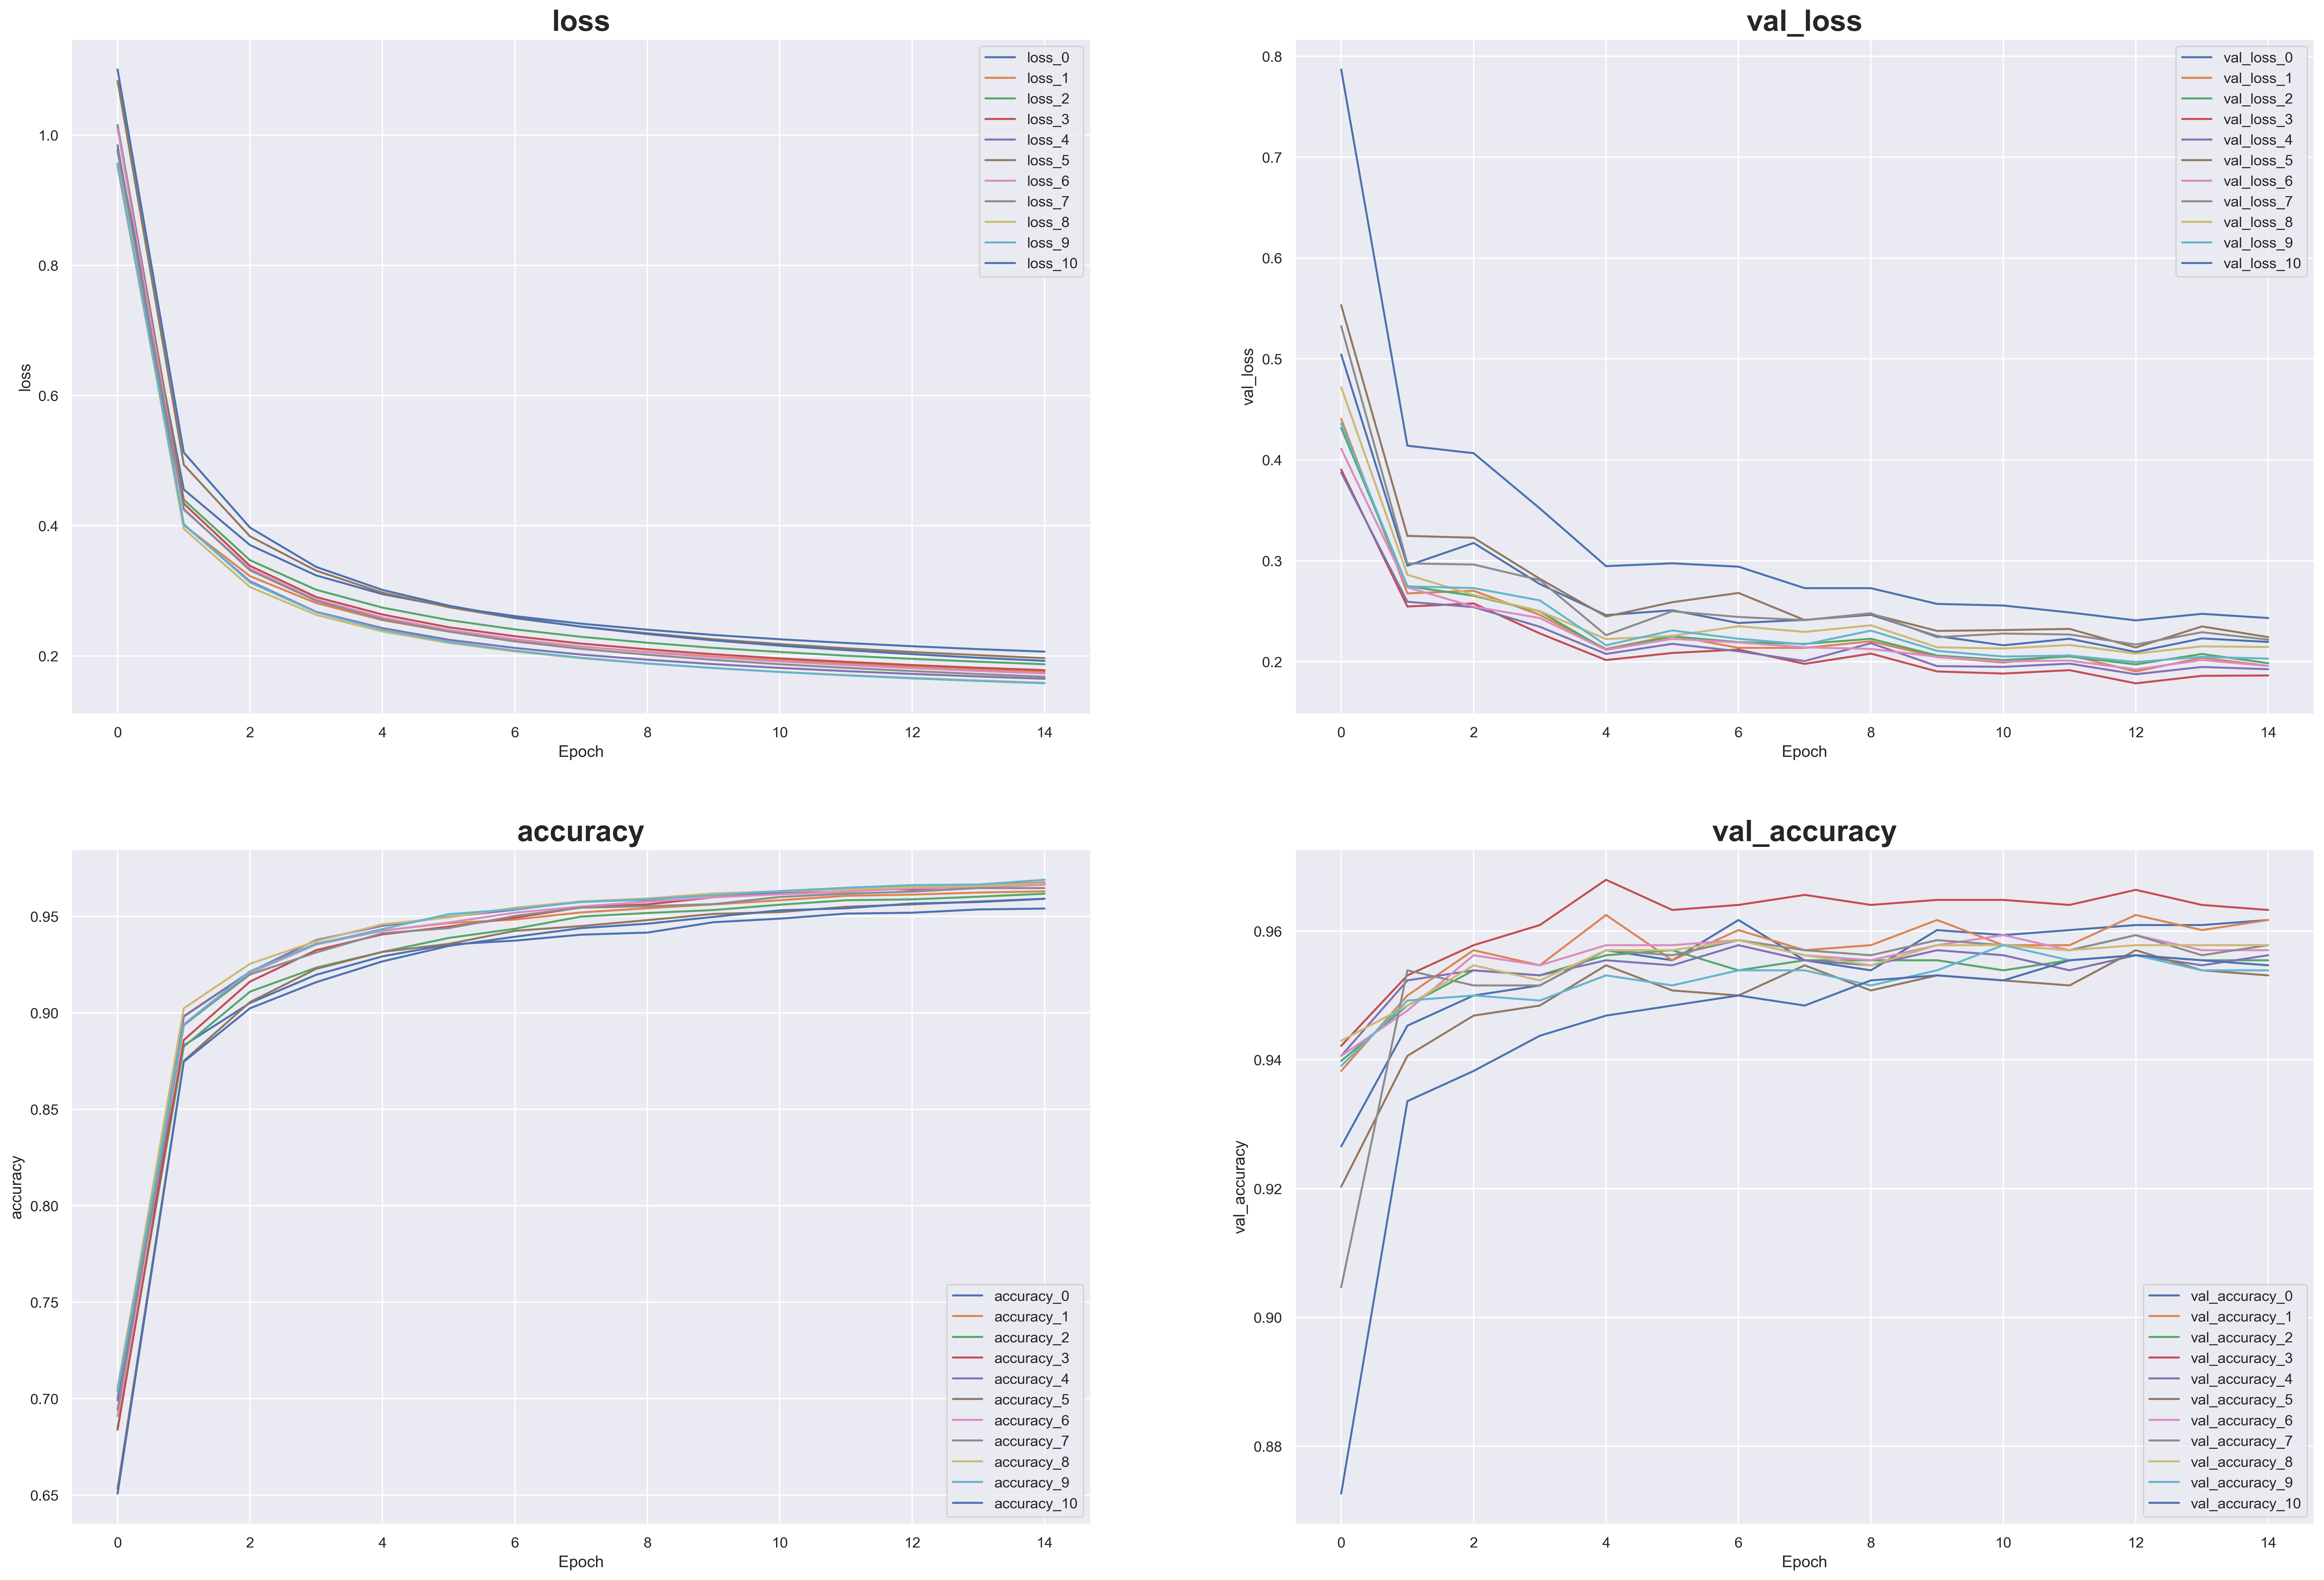

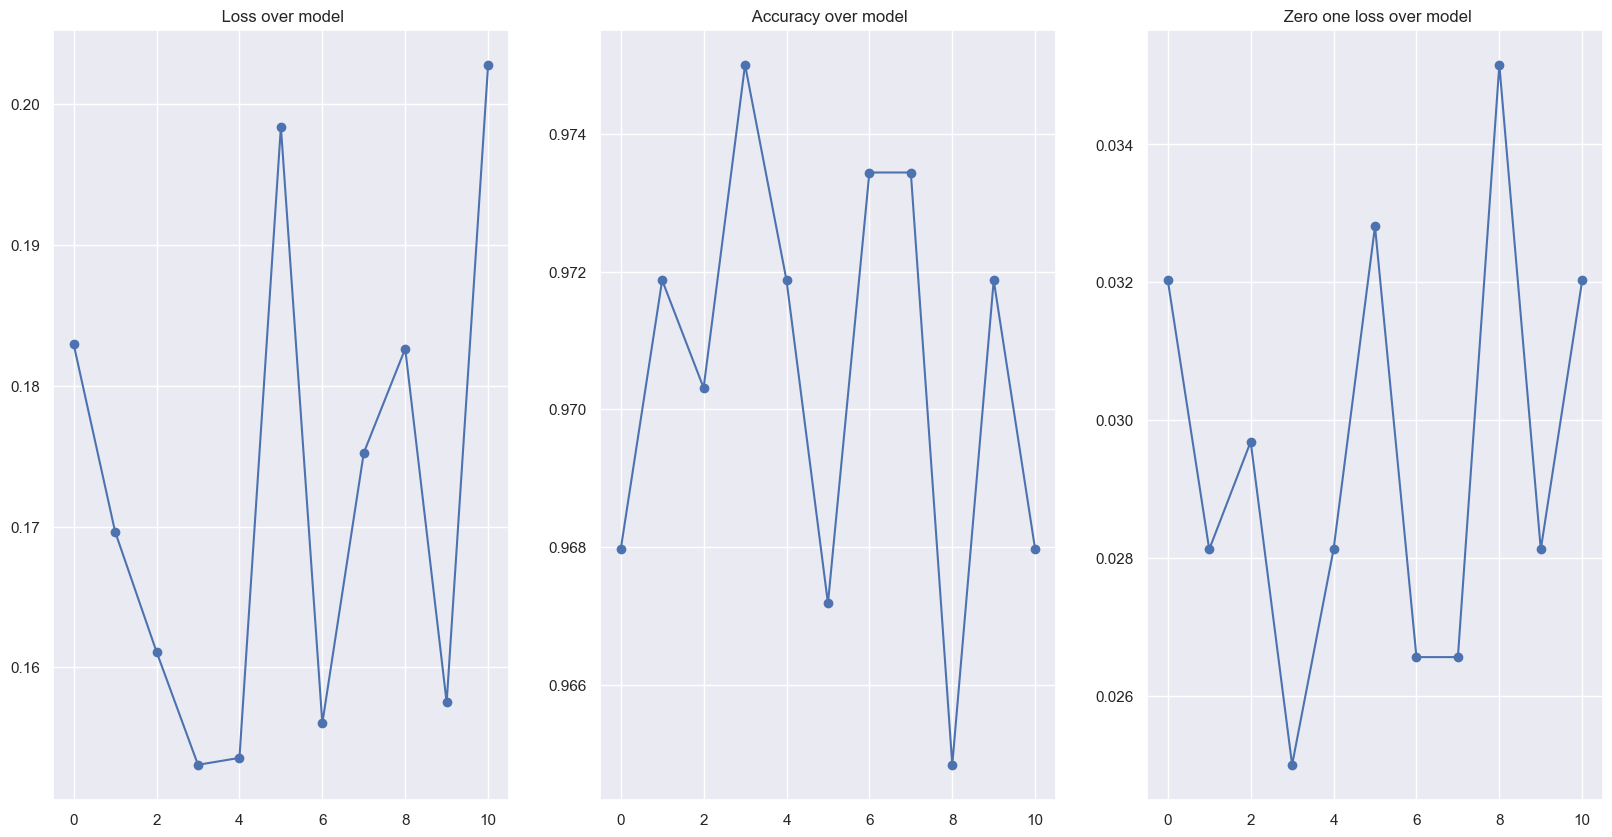

In [36]:
history_plot(history,score,zero_one)

In [ ]:
print('Best pca :',features[8])
number_of_features=features[8]

## Random search for other parameters

In [ ]:
#PARAMETERS
epochs = 15
batch_size = 32

n_neurons_per_layer = [50,100,400]
n_layers = [1,2,3]
n_categories = len(number2square)
eta= np.logspace(-3,2,4)
lmbd=np.logspace(-6,-1,4)
opt=[optimizers.SGD, optimizers.Adam,optimizers.RMSprop,optimizers.Adagrad]
activation=['sigmoid','elu','tanh'] 


In [ ]:
models_DNN=[]
history=[]
score=[]
zero_one=[]


np.random.seed(2)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)
print("Number of principal components: ",number_of_features)
tt_train,tt_valid,tt_test=PCA_func(new_X_train_img,new_X_valid_img,new_X_test_img,number_of_features)
inputsize=number_of_features
for i in range(10):
    
    model=RandomSearch(n_neurons_per_layer,n_layers,eta,lmbd,opt,activation,epochs)
    models_DNN.append(model)
    
    history.append( model.fit(tt_train, Y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data=(tt_valid, Y_valid), callbacks=[callback],
                        verbose = 2

                      ))
    score.append(model.evaluate(tt_test, Y_test))
    
    Y_pred=model.predict(tt_test)
    zero_one.append(zero_one_loss(Y_test,Y_pred))
      

In [ ]:
history_plot(history,score,zero_one)

## Search for $\eta$ and $\lambda$

In [ ]:
#n_neurons_per_layer :400 
#n_layers :2 
#eta :0.046415888336127795 
#lmbd :4.641588833612782e-05 
#opt :<class 'keras.optimizers.optimizer_v2.adagrad.Adagrad'> 
#activation :elu

In [ ]:
print( np.logspace(-4,-1,4))

In [ ]:
#PARAMETERS
epochs = 15
batch_size = 32

n_neurons_per_layer = 400
n_layers = 2
n_categories = len(number2square)
eta_vals= np.logspace(-2,-1,4)
lmbd_vals=[0,10**(-3),10**(-5)]
opt=optimizers.Adagrad
activation='elu'

In [ ]:
models_DNN=[]
history=[]
score=[]
zero_one=[]


np.random.seed(2)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)
print("Number of principal components: ",number_of_features)
tt_train,tt_valid,tt_test=PCA_func(new_X_train_img,new_X_valid_img,new_X_test_img,number_of_features)
inputsize=number_of_features
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        model=DNN_model(n_neurons_per_layer, n_layers, n_categories, eta, lmbd , opt ,inputsize,activation,epochs)
        models_DNN.append(model)
    
        history.append( model.fit(tt_train, Y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data=(tt_valid, Y_valid), callbacks=[callback],
                        verbose = 2

                      ))
        score.append(model.evaluate(tt_test, Y_test))
    
        Y_pred=model.predict(tt_test)
        zero_one.append(zero_one_loss(Y_test,Y_pred))

In [ ]:
history_plot(history,score,zero_one)

In [ ]:
grid_plot(score,eta_vals,lmbd_vals)

In [ ]:
# Model 9
#print(eta_vals[3],' , ',lmbd_vals[0])
#parameters
FFNN=models_DNN[9]
epochs = 15
batch_size = 32

n_neurons_per_layer = 400
n_layers = 2
n_categories = len(number2square)
eta_vals= 0.1
lmbd_vals=0
opt=optimizers.Adagrad
activation='elu'

In [ ]:
np.random.seed(1888)
# Per mostrare le immagini sul notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (26,12)
# choose some random images to display
indices = np.arange(len(tt_test))
random_indices = np.random.choice(indices, size=10)
Y_pred=FFNN.predict(tt_test)


for i in range(len(random_indices)):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    image = new_X_test_img[random_indices[i]].reshape(32, 32)
    plt.imshow(image, cmap="gray")
    plt.title("Predicted : "+number2square[np.argmax(Y_pred[random_indices[i]])])
plt.show()


In [ ]:
np.random.seed(1888)
# Per mostrare le immagini sul notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (26,12)
# choose some random images to display
#indices = np.arange(len(tt_test))
#random_indices = np.random.choice(indices, size=10)
Y_pred=FFNN.predict(tt_test)


for i in range(len(tt_test)):
    if(np.argmax(Y_test[i]) !=np.argmax(Y_pred[i])):
        
        plt.figure(figsize=(2,2))
        plt.axis('off')
        image =  new_X_test_img[i].reshape(32, 32)
        plt.imshow(image, cmap="gray")
        plt.title("Predicted : "+number2square[np.argmax(Y_pred[i])])
        plt.show()

In [ ]:
# Fen Notation
Fen = {
  
    "1": 0,
    "p": 1,
    "r": 2,
    "n": 3,
    "b": 4,
    "q": 5,
    "k": 6,
    "P": 7,
    "R": 8,
    "N": 9,
    "B": 10,
    "Q": 11,
    "K": 12

}
number2Fen={}
for pieces,i in Fen.items():
        
        number2Fen[i]= pieces

# CNN

In [ ]:
X_train_CNN=X_train.reshape(len(X_train),32,32)
X_test_CNN=X_test.reshape(len(X_test),32,32)
X_valid_CNN=X_valid.reshape(len(X_valid),32,32)


In [ ]:
def RandomSearch_CNN(receptive_field,n_filters, n_neurons_connected, n_categories,eta, lmbd,opt,epochs, model):
    i = np.random.randint(len(receptive_field))
    j = np.random.randint(len(n_filters))
    p = np.random.randint(len(n_neurons_connected))
    k = np.random.randint(len(eta))
    t = np.random.randint(len(lmbd))
    w = np.random.randint(len(opt))
    
    print('receptive_field :{} \nn_filters :{} \nn_neurons_connected :{} \neta :{} \nlmbd :{} \nopt :{} '.format(receptive_field[i], n_filters[j],n_neurons_connected[p], eta[k], lmbd[t] , opt[w] ))
    return model(receptive_field[i], n_filters[j], n_neurons_connected[p],n_categories, eta[k], lmbd[t] , opt[w],epochs )


In [ ]:
def one_CNN( receptive_field,n_filters, n_neurons_connected, n_categories,eta, lmbd,opt,epochs):
    
    model = Sequential()
    model.add(tf.keras.layers.Conv2D(n_filters, (receptive_field, receptive_field), input_shape=(32,32,1), padding='same',
              activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(n_filters*2, (receptive_field, receptive_field), input_shape=(32,32,1), padding='same',
              activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_neurons_connected, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dense(n_categories, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))
    
    model.compile(loss='categorical_crossentropy',optimizer=opt(lr=eta),metrics=['accuracy'])
    return model

eta_vals= [0.1,0.01,0.001] 

lmbd_vals= [0,10**(-3),10**(-6)] 
opt=[optimizers.SGD, optimizers.Adam]

epochs = [10,15,20]
batch_size = [32,64]

receptive_field = [3,5]
n_filters = [16,32,64]
n_neurons_connected = [50,200,400]
n_categories =  len(number2square)


In [ ]:
#number of epochs :  15
#batch_size :  64
#receptive_field :3 
#n_filters :16 
#n_neurons_connected :200 
#eta :0.1 
#lmbd :1e-06 
#sgd

In [ ]:
models_CNN_oneC=[]
history_oneC=[]
score_oneC=[]
zero_one_oneC=[]



np.random.seed(1)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)

for i in range(10):
    a = np.random.randint(len(epochs))
    b = np.random.randint(len(batch_size))
    E=epochs[a]
    B=batch_size[b]
    print('number of epochs : ',E)
    print('batch_size : ',B)
    model=RandomSearch_CNN(receptive_field,n_filters, n_neurons_connected, n_categories,eta_vals, lmbd_vals,opt,E, one_CNN)
    models_CNN_oneC.append(model)
    
    history_oneC.append( model.fit(X_train_CNN,Y_train,
                        batch_size = B,
                        epochs = E,
                        validation_data=(X_valid_CNN, Y_valid), callbacks=[callback],
                        verbose = 2

                      ))
    score_oneC.append(model.evaluate(X_test_CNN, Y_test))
    
    Y_pred=model.predict(X_test_CNN)
    zero_one_oneC.append(zero_one_loss(Y_test,Y_pred))
    

In [ ]:
history_plot(history_oneC,score_oneC,zero_one_oneC)

In [ ]:
# Fine tuning for the 3 model
#number of epochs :  10
#batch_size :  32
#receptive_field :5 
#n_filters :64 
#n_neurons_connected :50 
#eta :0.1 
#lmbd :1e-06
#SGD

In [ ]:
eta_vals= [0.01, 0.1] 
lmbd_vals= [10**(-6),10**(-3)] 
opt=optimizers.SGD

epochs = 10
batch_size = 32

receptive_field = 5
n_filters = 64
n_neurons_connected= 50
n_categories =  len(number2square)


In [ ]:
models_CNN_twoC=[]
history_twoC=[]
score_twoC=[]
zero_one_twoC=[]



np.random.seed(1)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        print('eta : {} \nlambda : {}'.format(eta_vals[i],lmbd_vals[j]))
        model=one_CNN(receptive_field,n_filters, n_neurons_connected, n_categories,eta_vals[i], lmbd_vals[j],opt,epochs)
        models_CNN_twoC.append(model)
    
        history_twoC.append( model.fit(X_train_CNN,Y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data=(X_valid_CNN, Y_valid), callbacks=[callback],
                        verbose = 2

                      ))
        score_twoC.append(model.evaluate(X_test_CNN, Y_test))
    
        Y_pred=model.predict(X_test_CNN)
        zero_one_twoC.append(zero_one_loss(Y_test,Y_pred))

In [ ]:
history_plot(history_twoC,score_twoC,zero_one_twoC)
grid_plot(score_twoC,eta_vals,lmbd_vals)

In [ ]:
# 3 model
eta=  0.1 
lmbd= 10**(-6)
opt=optimizers.SGD

epochs = 15 #because of drop
batch_size = 32

receptive_field = 5
n_filters = 64
n_neurons_connected= 50
n_categories =  len(number2square)


In [ ]:
CNN=models_CNN_twoC[2]

In [ ]:
# Errors of best models for ffnn and CNN

In [ ]:
print('FFNN')

Y_pred=FFNN.predict(tt_test,verbose=0)
errors=0
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i]) !=np.argmax(Y_pred[i])):
        print('Label : {} Predicted : {}'.format(number2Fen[np.argmax(Y_test[i])].ljust(15),number2Fen[np.argmax(Y_pred[i])]))
        errors += 1
print('number of errors : ',errors)

print('\nCNN')
Y_pred=CNN.predict(X_test_CNN,verbose=0)
errors=0
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i]) !=np.argmax(Y_pred[i])):
        print('Label : {} Predicted : {}'.format(number2Fen[np.argmax(Y_test[i])].ljust(15),number2Fen[np.argmax(Y_pred[i])]))
        errors += 1
print('number of errors : ',errors)
    


# More tests

In [ ]:
from PIL import Image
import IPython
from IPython.core.display import Markdown
from IPython.display import  display
from matplotlib.image import imread
import urllib.request


In [ ]:

def fen_CNN(path_to_image):
    image = Image.open(path_to_image).convert('L')
    image=image.resize((32*8, 32*8))
    Fen_string="/"
    
    for j in range(8):
        nb=0
        for i in range(8):
            box = (0+32*i, 0+32*j, 32+32*i, 32+32*j)
            im = image.crop(box)
            im=im.resize((32, 32))
            pix_val = np.asarray(im)
            pix_val =(pix_val)/ 255
            pix_val=pix_val.reshape(1,32,32,1)
            pred=models_CNN_twoC[3].predict(pix_val,verbose=0)
            if ((i==0)&(j !=0) ):
                   Fen_string=Fen_string+'/'
            if (str(number2Fen[np.argmax(pred)])=='1'):
                nb +=1
            else:
                if (nb != 0):
                    Fen_string=Fen_string+(str(nb))
                Fen_string=Fen_string+(str(number2Fen[np.argmax(pred)]))
                nb=0
                
        if (nb !=0):
            Fen_string=Fen_string+(str(nb))

    return Fen_string


def fen_FFNN(path_to_image):
    image = Image.open(path_to_image).convert('L')
    image=image.resize((32*8, 32*8))
    Fen_string="/"
    pca = PCA(n_components=number_of_features)
    pca.fit(new_X_train_img)
    for j in range(8):
        nb=0
        for i in range(8):
            
            box = (0+32*i, 0+32*j, 32+32*i, 32+32*j)
            im = image.crop(box)
            im=im.resize((32, 32))
            pix_val = np.asarray(im.getdata())
            pix_val =(pix_val.reshape(1,-1))/ 255
            sc = scaler.transform(pix_val)
            pix_val = pca.transform(sc)
            pred=FFNN.predict(pix_val,verbose=0)
            if ((i==0)&(j !=0) ):
                   Fen_string=Fen_string+'/'
            
            
            if (str(number2Fen[np.argmax(pred)])=='1'):
                nb +=1
            else:
                if (nb != 0):
                    Fen_string=Fen_string+(str(nb))
                Fen_string=Fen_string+(str(number2Fen[np.argmax(pred)]))
                nb=0
                
        if (nb !=0):
            Fen_string=Fen_string+(str(nb))
    
    return Fen_string

def display_image_with_fen(Fen_string_FFNN,Fen_string_CNN,original,fen):
    
    
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' % Fen_string_FFNN, "result/FFNN.jpg")
    #display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis%s)" % Fen_string))
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' % Fen_string_CNN, "result/CNN.jpg")
    print('FEN  : ',fen)
    
    if (Fen_string_FFNN == fen):
        print('FFNN : CORRECT')
    else:
        print('FFNN : ERROR')
        string =''
        for i in range(len(Fen_string_FFNN)):
            if (Fen_string_FFNN[i] == fen[i]):
                string = string + 'x'
            else :
                string = string + fen[i]
        print('    FFNN : ',Fen_string_FFNN)
        print('         : ',string)
        
        
    if (Fen_string_CNN == fen):
        print('CNN : CORRECT')
    else:
        print('CNN : ERROR')
        string =''
        for i in range(len(Fen_string_CNN)):
            if (Fen_string_CNN[i] == fen[i]):
                string = string + 'x'
            else :
                string = string + fen[i]
        print('    CNN : ',Fen_string_CNN)
        print('         : ',string)  
    
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.title('Original',weight="bold",size=22)
    image =imread(original)
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')
    
    plt.subplot(132)
    plt.title('Predicted FFNN',weight="bold",size=22)
    image = imread('result/FFNN.jpg')
    
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')
    
    plt.subplot(133)
    plt.title('Predicted CNN',weight="bold",size=22)
    image = imread('result/CNN.jpg')
    
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')
    plt.show()
def display_image(Fen_string_FFNN,Fen_string_CNN,original):
    
    
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' % Fen_string_FFNN, "result/FFNN.jpg")
    #display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis%s)" % Fen_string))
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' % Fen_string_CNN, "result/CNN.jpg")
    if (Fen_string_FFNN == Fen_string_CNN):
        print('Equal predictions')
    else:
        print('Different predictions')
        
    
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.title('Original',weight="bold",size=22)
    image =imread(original)
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')
    
    plt.subplot(132)
    plt.title('Predicted FFNN',weight="bold",size=22)
    image = imread('result/FFNN.jpg')
    
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')
    
    plt.subplot(133)
    plt.title('Predicted CNN',weight="bold",size=22)
    image = imread('result/CNN.jpg')
    
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
    
def display_fen(Fen_string_FFNN,Fen_string_CNN,original,fen):
    
    
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' % Fen_string_FFNN, "result/FFNN.jpg")
    #display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis%s)" % Fen_string))
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' % Fen_string_CNN, "result/CNN.jpg")
    
    if (Fen_string_FFNN == fen):
        print('FFNN : CORRECT')
    else:
        print('FFNN : ERROR')
        string =''
        for i in range(len(Fen_string_FFNN)):
            if (Fen_string_FFNN[i] == fen[i]):
                string = string + 'x'
            else :
                string = string + fen[i]
        print('    FFNN : ',Fen_string_FFNN)
        print('         : ',string)
        print('    FEN  : ',fen)
    
        
    if (Fen_string_CNN == fen):
        print('CNN : CORRECT')
    else:
        print('CNN : ERROR')
        string =''
        for i in range(len(Fen_string_CNN)):
            if (Fen_string_CNN[i] == fen[i]):
                string = string + 'x'
            else :
                string = string + fen[i]
        print('    CNN : ',Fen_string_CNN)
        print('        : ',string)  
        print('    FEN : ',fen)
  

In [ ]:
FEN_test=[]

    
def getRandomFEN():
    
    Fen_string="/"
    for j in range(8):
        nb=0
        for i in range(8):
            piece = number2Fen[random.randint(0,len(number2Fen)-1)]
            
            if ((i==0)&(j !=0) ):
                   Fen_string=Fen_string+'/'
            
            if (piece=='1'):
                nb +=1
            else:
                if (nb != 0):
                    Fen_string=Fen_string+(str(nb))
                
                Fen_string=Fen_string+(str(piece))
                nb=0
                
        if (nb !=0):
            Fen_string=Fen_string+(str(nb))
    return Fen_string

def PredictRandomImage_with_Image():
    fen=getRandomFEN()
    image_path ='result/Gen.jpg'
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' %fen, image_path)
    #print('http://www.fen-to-image.com/image%s' % fen)
    display_image_with_fen(fen_FFNN(image_path),fen_CNN(image_path),image_path,fen)
   

def PredictRandomImage():
    fen=getRandomFEN()
    image_path ='result/Gen.jpg'
    urllib.request.urlretrieve('http://www.fen-to-image.com/image%s' %fen, image_path)
    #print('http://www.fen-to-image.com/image%s' % fen)
    display_fen(fen_FFNN(image_path),fen_CNN(image_path),image_path,fen)
    


In [ ]:
for i in range(10):
    print('\nTest : ',i+1)
    PredictRandomImage()
    

In [ ]:
folder_dir = "chess_position/"
for images in os.listdir(folder_dir):
# check if the image ends with png
    if (images.endswith(".png")):
        display_image(fen_FFNN(folder_dir+images),fen_CNN(folder_dir+images),folder_dir+images)


In [ ]:
df1